In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [290]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from joblib import dump
from scipy.stats import norm, multivariate_normal
import lightgbm as lgb
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pickle as pkl
import joblib as joblib
features = ['Month', 'Hour', 'hour_x', 'hour_y', 'month_x', 'month_y',
'net_target-23', 'diffuse_solar_radiation+1', 'direct_solar_radiation+1', 'relative_humidity+1', 'drybulb_temp+1']
target = 'net_target'

In [305]:
forecast = pd.read_csv('debug_logs/scenarios_point_recurrent_9000_1.csv')
forecast

,time_step,scenario,building,+1h,+2h,+3h,+4h,+5h,+6h,+7h,...,+15h,+16h,+17h,+18h,+19h,+20h,+21h,+22h,+23h,+24h
0,0,0,0,0.737881,0.344792,-0.100352,-0.039405,0.038974,0.026710,-0.667358,...,-2.368901,-2.023600,-1.635879,-1.050545,-0.229833,0.072593,0.059910,-0.026226,-0.026191,-0.071121
1,0,0,1,0.519483,0.199971,-0.129194,-0.063702,-0.103141,-0.112332,-0.632428,...,-1.907470,-1.648721,-1.358184,-0.919567,-0.304571,-0.077950,-0.087453,-0.151999,-0.151972,-0.185641
2,0,0,2,-0.332168,-0.602513,-0.842794,-0.801691,-0.748832,-0.757103,-1.225185,...,-2.372712,-2.139839,-1.878359,-1.483608,-0.930116,-0.726159,-0.734713,-0.792803,-0.792779,-0.823081
3,0,0,3,0.732954,-0.142657,-0.383004,-0.613359,-0.601909,-0.610345,-1.087744,...,-2.258113,-2.020605,-1.753920,-1.351311,-0.786802,-0.578785,-0.587509,-0.646756,-0.646731,-0.677636
4,0,0,4,0.079354,-0.215069,-0.492037,-0.499149,-0.535429,-0.543883,-1.022317,...,-2.195222,-1.957200,-1.689937,-1.286455,-0.720723,-0.512255,-0.520997,-0.580373,-0.580348,-0.611320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,8759,0,0,1.830613,1.093297,0.713260,0.716735,0.721737,0.765454,0.695488,...,0.093729,0.552745,0.965864,1.535550,1.926750,1.757545,1.887569,2.158329,2.417111,2.347384
43796,8759,0,1,1.902718,0.859199,0.823265,0.820058,0.886900,0.611825,0.450529,...,0.319728,0.585658,0.667099,0.773370,0.933223,1.185214,1.226577,1.482469,1.410149,1.685158
43797,8759,0,2,0.046039,0.050680,0.075655,0.099856,0.141912,0.170700,0.210251,...,-0.727149,-0.263699,0.041003,0.269161,0.544257,0.750464,0.889015,0.972730,1.022416,0.496470
43798,8759,0,3,1.778213,1.438327,1.268036,1.005865,0.735524,0.833445,0.616311,...,0.101265,0.137206,0.393378,0.805132,1.100058,1.154574,0.969148,0.881046,1.110139,1.293626


In [331]:
power = pd.read_csv('debug_logs/real_power_point_recurrent_9000_1.csv')

In [332]:
power = power.melt(id_vars=['time_step'], var_name='building', value_name='net_load')
# only keep values after _ in building column
power['building'] = power['building'].str.split('_').str[1].astype(int)
# remove first row
power = power.iloc[1:]
# add shifted 24 hours horizon columns of net_target
for i in range(1, 25):
    power[f'net_load+{i}'] = power['net_load'].shift(-i)
# drop row with NaN values
power = power.dropna()
# drop net_load column
power = power.drop(columns=['net_load'])
power

,time_step,building,net_load+1,net_load+2,net_load+3,net_load+4,net_load+5,net_load+6,net_load+7,net_load+8,...,net_load+15,net_load+16,net_load+17,net_load+18,net_load+19,net_load+20,net_load+21,net_load+22,net_load+23,net_load+24
1,0,0,0.834600,0.838167,1.478433,1.256200,1.811500,0.362733,-0.489917,-1.184867,...,-0.298267,0.059700,1.054850,1.006983,3.603983,5.008500,3.896217,3.557083,1.411333,0.979417
2,1,0,0.838167,1.478433,1.256200,1.811500,0.362733,-0.489917,-1.184867,-1.809783,...,0.059700,1.054850,1.006983,3.603983,5.008500,3.896217,3.557083,1.411333,0.979417,0.900975
3,2,0,1.478433,1.256200,1.811500,0.362733,-0.489917,-1.184867,-1.809783,-2.205867,...,1.054850,1.006983,3.603983,5.008500,3.896217,3.557083,1.411333,0.979417,0.900975,0.922433
4,3,0,1.256200,1.811500,0.362733,-0.489917,-1.184867,-1.809783,-2.205867,-2.274867,...,1.006983,3.603983,5.008500,3.896217,3.557083,1.411333,0.979417,0.900975,0.922433,0.910483
5,4,0,1.811500,0.362733,-0.489917,-1.184867,-1.809783,-2.205867,-2.274867,-1.572750,...,3.603983,5.008500,3.896217,3.557083,1.411333,0.979417,0.900975,0.922433,0.910483,1.010300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,8730,4,0.457167,0.714717,1.659000,1.103167,1.343600,0.995117,0.951033,0.608817,...,-0.446800,-0.499950,0.456283,0.140883,0.522200,1.169617,1.663533,3.119600,3.839883,2.713900
43772,8731,4,0.714717,1.659000,1.103167,1.343600,0.995117,0.951033,0.608817,0.594300,...,-0.499950,0.456283,0.140883,0.522200,1.169617,1.663533,3.119600,3.839883,2.713900,0.935833
43773,8732,4,1.659000,1.103167,1.343600,0.995117,0.951033,0.608817,0.594300,0.376467,...,0.456283,0.140883,0.522200,1.169617,1.663533,3.119600,3.839883,2.713900,0.935833,2.155017
43774,8733,4,1.103167,1.343600,0.995117,0.951033,0.608817,0.594300,0.376467,0.444233,...,0.140883,0.522200,1.169617,1.663533,3.119600,3.839883,2.713900,0.935833,2.155017,2.316400


In [333]:
# for the matching time steps, merge the forecast and power dataframes
forecast = forecast.merge(power, how='inner', on=['time_step', 'building'])

In [334]:
forecast

,time_step,scenario,building,+1h,+2h,+3h,+4h,+5h,+6h,+7h,...,net_load+15,net_load+16,net_load+17,net_load+18,net_load+19,net_load+20,net_load+21,net_load+22,net_load+23,net_load+24
0,0,0,0,0.737881,0.344792,-0.100352,-0.039405,0.038974,0.026710,-0.667358,...,-0.298267,0.059700,1.054850,1.006983,3.603983e+00,5.008500e+00,3.896217e+00,3.557083e+00,1.411333e+00,9.794167e-01
1,0,0,1,0.519483,0.199971,-0.129194,-0.063702,-0.103141,-0.112332,-0.632428,...,0.204017,-0.572450,-0.678733,-0.069417,3.583334e-01,1.584500e+00,2.561233e+00,1.434200e+00,4.132075e+00,2.900917e+00
2,0,0,2,-0.332168,-0.602513,-0.842794,-0.801691,-0.748832,-0.757103,-1.225185,...,-1.743550,-1.656633,-0.879733,-0.045600,1.011848e-07,1.003265e-07,1.000817e-07,1.015007e-07,1.034101e-07,9.991129e-08
3,0,0,3,0.732954,-0.142657,-0.383004,-0.613359,-0.601909,-0.610345,-1.087744,...,-2.074017,-0.055433,0.160417,0.149917,1.557933e+00,2.832317e+00,6.387667e-01,7.265167e-01,2.649125e+00,4.703167e-01
4,0,0,4,0.079354,-0.215069,-0.492037,-0.499149,-0.535429,-0.543883,-1.022317,...,-0.137150,0.023717,2.313683,1.957267,1.498883e+00,2.606917e+00,1.278900e+00,1.098700e+00,1.060992e+00,3.063000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43766,8757,0,3,1.268422,1.322211,1.410212,1.260994,1.180815,0.858036,0.739260,...,-1.810483,-0.152117,-0.109050,-0.137150,2.371667e-02,2.313683e+00,1.957267e+00,1.498883e+00,2.606917e+00,1.278900e+00
43767,8758,0,0,1.961151,1.836744,0.957034,0.785600,0.748177,0.768787,0.779483,...,0.924617,0.935333,0.204017,-0.572450,-6.787332e-01,-6.941661e-02,3.583334e-01,1.584500e+00,2.561233e+00,1.434200e+00
43768,8758,0,1,1.836834,1.774316,0.654268,0.697268,0.723909,0.821337,0.655283,...,-1.296567,-1.413883,-1.743550,-1.656633,-8.797332e-01,-4.559990e-02,1.011848e-07,1.003265e-07,1.000817e-07,1.015007e-07
43769,8758,0,2,0.912556,0.754576,0.471826,0.399083,0.330931,0.312721,0.299903,...,-2.687133,-1.972850,-2.074017,-0.055433,1.604167e-01,1.499167e-01,1.557933e+00,2.832317e+00,6.387667e-01,7.265167e-01


In [336]:
# substact the forecast from the real power
for i in range(1, 25):
    forecast[f'error+{i}'] = forecast[f'net_load+{i}'] - forecast[f'+{i}h']

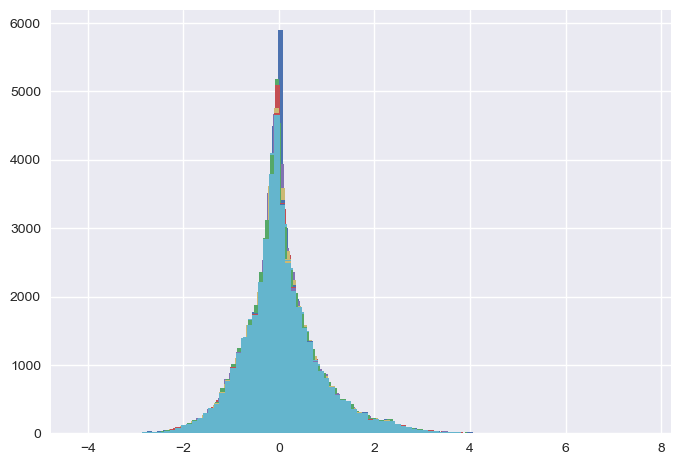

In [344]:
# plot distribution of error+1
for i in range(1, 25):
    plt.hist(forecast[f'error+{i}'], bins=100)
plt.show()